<a href="https://colab.research.google.com/github/antonum/Redis-Workshops/blob/experimental/kamran-redis/RAG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Copied from [LangChain: Chat with Your Data](https://learn.deeplearning.ai/langchain-chat-with-your-data)** Use the short course to learn about RAG. **This is only tested on M1 using python 3.10**.
[source](https://learn.deeplearning.ai/microsoft-semantic-kernel/lesson/1/introduction)
![DLAI_-_Learning_Platform_Beta.png](attachment:c9bf3282-1a0c-4258-803b-d567f5741d92.png)

![DLAI_-_Learning_Platform_Beta_🔊.png](attachment:f193025a-3364-4787-b6a4-8141adaccb47.png)

## Retrieval Augmented Generation

In retrieval augmented generation (RAG), an LLM retrieves contextual documents from an external dataset as part of its execution.

This is useful if we want to ask question about specific documents (e.g., our PDFs, a set of videos, etc).


RAG allows Grounding LLMs:
* Access information outside of training data
* Integrate with existing IT systems, databases,
and business data
* Mitigate risk of hallucinations


This notebook uses [langchain](https://python.langchain.com/) and is changed to run offline on local machine.
* Uses [llama.cpp](https://github.com/ggerganov/llama.cpp) as inference engine by running a local openAI API compatible server.
* HuggingFace local embedding

**Code to run with Azure AI is at the bottom**

## Redis  
![CleanShot 2023-10-06 at 21.37.56@2x.png](attachment:0424fda2-0313-46e6-9ba1-0c1bb6b7afdf.png)

* Retrieving contextual data for RAG using [Redis as a Vector Database](https://python.langchain.com/docs/integrations/vectorstores/redis)
* [Semantic Cache](https://python.langchain.com/docs/integrations/llms/llm_caching#semantic-cache) for prompts based on semantic similarity between the prompt and previously cached results
* [Chat Memory History](https://python.langchain.com/docs/integrations/memory/redis_chat_message_history)



![overview.jpeg](attachment:overview.jpeg)

In [1]:
! pip install -q langchain openai sentence_transformers pypdf gradio tiktoken scikit-learn redis


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 816.1/816.1 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.7/226.7 kB 13.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.8/132.8 kB 13.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 284.0/284.0 kB 20.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.9/16.9 MB 35.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 56.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 250.3/250.3 kB 23.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 43.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.1/242.1 kB 25.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.1/92.1 kB 9.2 MB/s eta 0:00:00
  Preparing metadata (se

In [53]:
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.llms import OpenAI
from langchain.chat_models import ChatOpenAI
import langchain
import getpass

openai_api_key = getpass.getpass(prompt='OpenAI Key: ', stream=None)
#openai_api_base ="http://localhost:8081/v1"

temprature_default=0.8
temprature_max=1.0
top_p_default=0.95
top_p_max=1.0
max_tokens_default=256
max_tokens_max=4000

def getLLM(temperature=0.8, top_p=0.95, max_tokens=256):
    return OpenAI(model_name="gpt-3.5-turbo-instruct",
                 openai_api_key= openai_api_key,
                  max_retries=1,max_tokens=max_tokens,top_p=top_p,temperature=temperature,) #model_kwargs={"top_p":top_p}

def getChatLLM(temperature=0.8, top_p=0.95, max_tokens=256):
       return ChatOpenAI(model_name="gpt-3.5-turbo",
                 openai_api_key= openai_api_key, max_retries=1,
                 temperature=temperature,max_tokens=max_tokens,model_kwargs={"top_p":top_p} ,) #
def getEmbeddings():
    return HuggingFaceEmbeddings()



OpenAI Key: ··········


In [3]:

%%sh
curl -fsSL https://packages.redis.io/gpg | sudo gpg --dearmor -o /usr/share/keyrings/redis-archive-keyring.gpg
echo "deb [signed-by=/usr/share/keyrings/redis-archive-keyring.gpg] https://packages.redis.io/deb $(lsb_release -cs) main" | sudo tee /etc/apt/sources.list.d/redis.list
sudo apt-get update  > /dev/null 2>&1
sudo apt-get install redis-stack-server  > /dev/null 2>&1
redis-stack-server --daemonize yes


deb [signed-by=/usr/share/keyrings/redis-archive-keyring.gpg] https://packages.redis.io/deb jammy main
Starting redis-stack-server, database path /var/lib/redis-stack


# Document Loading

## PDF Document

Let's load a PDF document

In [4]:
from langchain.document_loaders import PyPDFLoader
loaders = [
    PyPDFLoader("https://raw.githubusercontent.com/kamran-redis/rag/main/docs/Buyers Guide for Enterprise Caching (2022-02).pdf"),
    PyPDFLoader("https://raw.githubusercontent.com/kamran-redis/rag/main/docs/the-economist- corporate-espionage-is-entering-a-new-era.pdf"),
    PyPDFLoader("https://raw.githubusercontent.com/kamran-redis/rag/main/docs/How Silicon Valley is helping the Pentagon in the AI arms race _ Financial Times.pdf"),
    PyPDFLoader("https://raw.githubusercontent.com/kamran-redis/rag/main/docs/2022-chevrolet-colorado-ebrochure.pdf"),
    #PyPDFLoader("docs/kubernetes-docs.pdf"),
    #PyPDFLoader("docs/rc-docs.pdf"),
    #PyPDFLoader("docs/ri-docs.pdf"),
    PyPDFLoader("https://raw.githubusercontent.com/kamran-redis/rag/main/docs/rs-docs.pdf"),
    #PyPDFLoader("docs/stack-docs.pdf")
]
pages = []
for loader in loaders:
    pages.extend(loader.load())

Each page is a `Document`.

A `Document` contains text (`page_content`) and `metadata`.

In [5]:
import gradio as gr

def pagenumber_change(n):
    page = pages[int(n)]
    return page.page_content,page.metadata

with gr.Blocks() as demopage:
    gr.Markdown("### Pages Content")
    page = gr.TextArea(label="Page Content",max_lines=10,value=pages[0].page_content)
    meta_data = gr.Textbox(label="MetaData",value=pages[0].metadata)
    page_number = gr.Slider(label="Page Number",  minimum=0, maximum= len(pages)-1, value=0,step=1, scale=1)
    page_number.release(pagenumber_change, inputs=[page_number], outputs=[page,meta_data])

demopage.launch()

Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://0a269c8792f8b2a9e6.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


## URLs

In [6]:
#from langchain.document_loaders import WebBaseLoader

#loader = WebBaseLoader("https://github.com/basecamp/handbook/blob/master/37signals-is-you.md")

In [7]:
#webdocs = loader.load()
#pages=webdocs

In [8]:
#print(webdocs[0].page_content[:500])

# Splitting Text

We will use `RecursiveCharacterTextSplitter` and also add lookback period as seperator

In [9]:
from langchain.text_splitter import RecursiveCharacterTextSplitter
r_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1500,
    chunk_overlap=50,
    separators=["\n\n", "\n", "(?<=\. )", " ", ""],
)

In [10]:
docs = r_splitter.split_documents(pages)

In [11]:
import gradio as gr

def docnumber_change(n):
    doc = docs[int(n)]
    return doc.page_content,doc.metadata

with gr.Blocks() as demodoc:
    gr.Markdown("### View Splitted Documents")
    doc_content = gr.TextArea(label="Document Content",max_lines=10,value=docs[0].page_content)
    doc_meta_data = gr.Textbox(label="MetaData",value=docs[0].metadata)
    doc_number = gr.Slider(label="Document Number",  minimum=0, maximum= len(docs)-1, value=0,step=1, scale=1)
    doc_number.release(docnumber_change, inputs=[doc_number], outputs=[doc_content,doc_meta_data])

demodoc.launch()

Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://fc2c3b09a2d30bd302.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


# Storage

## Embeddings
![Cursor_and_DLAI_-_Learning_Platform_Beta.png](attachment:1873a57c-b890-4740-9869-01f769840b90.png)

Other uses of embeddings other than similarity are

**Classification**
Train a random forest model to classify the category

**Anomaly / Outlier detection**
We can add an anomalous piece of text and check if the outlier (anomaly) detection algorithm (Isolation Forest) can identify it as an outlier (anomaly), based on its embedding.

In [12]:
from langchain.embeddings import HuggingFaceEmbeddings
from sklearn.metrics.pairwise import cosine_similarity
embedding = getEmbeddings()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [13]:
sentence1 = "i like dogs"
sentence2 = "i like canines"
sentence3 = "the weather is ugly outside"

In [14]:
embedding1 = embedding.embed_query(sentence1)
embedding2 = embedding.embed_query(sentence2)
embedding3 = embedding.embed_query(sentence3)

In [15]:
import numpy as np

In [16]:
len(embedding1)

768

In [17]:
embedding1[:10]

[-0.0136107811704278,
 0.11503762006759644,
 -0.02767833136022091,
 -0.04148174449801445,
 0.04854818433523178,
 0.03823169320821762,
 -0.045007556676864624,
 -0.01202703732997179,
 -0.0024974518455564976,
 -0.01713002286851406]

In [18]:
print(np.dot(embedding1, embedding2))
print(cosine_similarity([embedding1],[embedding2]))

0.8981181981809281
[[0.89811819]]


In [19]:
print(np.dot(embedding1, embedding3))
print(cosine_similarity([embedding1],[embedding3]))

0.03641026720280567
[[0.03641027]]


In [20]:
print(np.dot(embedding2, embedding3))
print(cosine_similarity([embedding2],[embedding3]))

0.0058476660108410326
[[0.00584767]]


###  Visualizing Embeddings [source](https://learn.deeplearning.ai/google-cloud-vertex-ai/lesson/4/visualizing-embeddings)

#### Embeddings capture meaning

In [21]:
in_1 = "Missing flamingo discovered at swimming pool"
in_2 = "Sea otter spotted on surfboard by beach"
in_3 = "Baby panda enjoys boat ride"

in_4 = "Breakfast themed food truck beloved by all!"
in_5 = "New curry restaurant aims to please!"

in_6 = "Python developers are wonderful people"
in_7 = "TypeScript, C++ or Java? All are great!"


input_text_lst_news = [in_1, in_2, in_3, in_4, in_5, in_6, in_7]

In [22]:
#Get embeddings for all pieces of text.
embeddings = []
for input_text in input_text_lst_news:
    emb = embedding.embed_query(input_text)
    embeddings.append(emb)

embeddings_array = np.array(embeddings)

In [23]:
print("Shape: " + str(embeddings_array.shape))
print(embeddings_array)

Shape: (7, 768)
[[ 0.01493032 -0.00331089 -0.02366721 ...  0.04382873 -0.00961944
   0.05507185]
 [ 0.02796176  0.05552787 -0.02646966 ...  0.04219671  0.02042511
   0.02744674]
 [-0.00396612  0.05514324 -0.01845468 ...  0.03014257  0.00855403
   0.01467848]
 ...
 [-0.00106709  0.07917724 -0.03888064 ...  0.04137965 -0.01599874
  -0.03126537]
 [ 0.02334456  0.03306935 -0.01906764 ...  0.00999067  0.08099694
  -0.03875096]
 [-0.00498157  0.02441759 -0.0479615  ...  0.00601145  0.0627252
  -0.01878871]]


#### Reduce embeddings from 768/1536 to 2 dimensions for visualization
- We'll use principal component analysis (PCA).
- You can learn more about PCA in [this video](https://www.coursera.org/learn/unsupervised-learning-recommenders-reinforcement-learning/lecture/73zWO/reducing-the-number-of-features-optional) from the Machine Learning Specialization.

In [24]:
from sklearn.decomposition import PCA

# Perform PCA for 2D visualization
PCA_model = PCA(n_components = 2)
PCA_model.fit(embeddings_array)
new_values = PCA_model.transform(embeddings_array)

In [25]:
print("Shape: " + str(new_values.shape))
print(new_values)

Shape: (7, 2)
[[ 0.5822739  -0.06701093]
 [ 0.59872601 -0.10793817]
 [ 0.31289851  0.00436359]
 [-0.29369953  0.58462128]
 [-0.29095232  0.56312781]
 [-0.32457206 -0.51324988]
 [-0.58467451 -0.4639137 ]]


In [26]:
! pip -q install matplotlib mplcursors ipympl


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.8/88.8 kB 3.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.6/511.6 kB 11.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 44.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 64.7 MB/s eta 0:00:00


In [27]:
from google.colab import output
output.enable_custom_widget_manager()

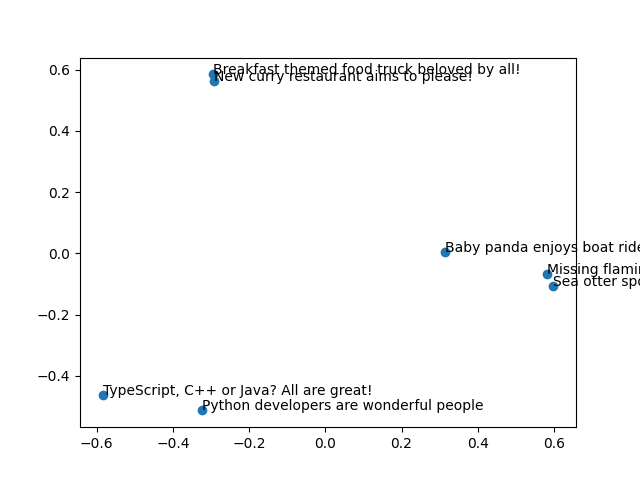

In [28]:
import matplotlib.pyplot as plt
import mplcursors
%matplotlib ipympl

#plt.plot(new_values[:,0], new_values[:,1], 'o')
fig, ax = plt.subplots()
ax.scatter(new_values[:,0], new_values[:,1])
for i, txt in enumerate(input_text_lst_news):
    ax.annotate(txt, (new_values[:,0][i], new_values[:,1][i]))

plt.show()
#from utils import plot_2D
#plot_2D(new_values[:,0], new_values[:,1], input_text_lst_news)

## Vector Stores
![Cursor_and_LangChain2_L3-v3_mp4.png](attachment:1f0fe6f9-2962-4f4d-8f2a-92dd7f19e634.png)
![LangChain2_L3-v3_mp4_and_DLAI_-_Learning_Platform_Beta.png](attachment:e1dafda2-a07d-4553-b4c5-192a4b208cd1.png)

In [29]:
redis_url = "redis://localhost:6379"
index_name = "docs"

In [30]:
from langchain.vectorstores.redis import Redis as RedisVectorStore
from langchain.embeddings import HuggingFaceEmbeddings

In [45]:
vectordb = RedisVectorStore.from_documents(documents=docs,
                                embedding=getEmbeddings(),
                                index_name=index_name,
                                redis_url=redis_url)

In [44]:
#!redis-cli keys "*"

# Retrieval

## Similarity Search

In [32]:
#question = "What is redis"
#vectordb.max_marginal_relevance_search(question,k=2,fetch_k=3)

In [33]:
import gradio as gr

def similaritySearch(question, k):
    #result= vectordb.similarity_search(question,k=int(k))
    result= vectordb.max_marginal_relevance_search(question,k=int(k),fetch_k=int(k) +1 )
    return "\n\n".join(str(x) for x in result)


with gr.Blocks() as demosearch:
    documents = gr.TextArea(label="Documents", max_lines=20)
    with gr.Row():
        search = gr.Textbox(label="Search",scale=5)
        k = gr.Number(label="# of Results", maximum=100, minimum=1, value=3,scale=1)
    with gr.Row():
         gr.Examples([['What is a good cache?'],["What are the minimum requirements to install redis enterprise?"],
                      ["What are the main differences between the three engine types available for the Chevy Colorado?"]],
                     [search],label="Example Searches",)
    with gr.Row():
        searchBtn = gr.Button("Search")
        clearButton = gr.ClearButton(components=[documents,search], value="Clear")
    search.submit(similaritySearch, inputs=[search, k],outputs=documents)
    searchBtn.click(similaritySearch, inputs=[search, k],outputs=documents)

gr.close_all()
demosearch.launch()

Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://2d623a8f929d853e20.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


# Question Answering

## LLM Model

## Add Redis Semantic Cache for prompts
Semantic caching allows users to retrieve cached prompts based on semantic similarity between the user input and previously cached results. Under the hood it blends Redis as both a cache and a vectorstore.

In [34]:
from langchain.cache import RedisSemanticCache
from langchain.embeddings import HuggingFaceEmbeddings
import langchain

# to delte cache redis-cli  --scan --pattern "doc:cache:*" -i 0.01 | xargs redis-cli  unlink

langchain.llm_cache = RedisSemanticCache(
    embedding=getEmbeddings(),
    redis_url=redis_url
)

In [55]:
import gradio as gr
from time import perf_counter_ns

prompt_template = """{prompt}"""

def askLLM(prompt, temperature, top_p,max_tokens):
    start = perf_counter_ns()

    llm = getLLM(temperature, top_p, max_tokens)
    completion= llm(prompt_template.format(prompt=prompt))

    stop = perf_counter_ns()
    elapasedTime= (stop - start) * 0.000001

    return completion, elapasedTime

#def clearCache():
#    langchain.llm_cache.clear()

with gr.Blocks() as demollm:
    with gr.Row():
        completion = gr.TextArea(label="Completion")
    with gr.Row():
        execution_time =gr.Textbox(label="Execution Time(ms)", scale=1)
        prompt = gr.Textbox(label="Prompt",scale=5, lines=3)
    with gr.Row():
        with gr.Column(scale=1):
            temperature = gr.Slider(label="temperature", maximum=temprature_max, minimum=0, value=temprature_default,step=0.1,scale=1)
            top_p = gr.Slider(label="top_p", maximum=top_p_max, minimum=0, value=top_p_default,step=0.05, scale=1)
            max_tokens = gr.Slider(label="max_tokens", maximum=max_tokens_max, minimum=-1, value=max_tokens_default, step=10, scale=3)
        with gr.Column(scale=2):
            gr.Examples([['When should I use Redis?'],["What is Redis?"],
                      ["Argue that earth is flat"],["What is the meaning of life"]],
                     [prompt],label="Example Prompts",)

    with gr.Row():
        askButton = gr.Button("Submit")
        clearButton = gr.ClearButton(components=[completion,prompt,execution_time],value="Clear")

    prompt.submit(askLLM, inputs=[prompt, temperature, top_p,max_tokens],outputs=[completion,execution_time])
    askButton.click(askLLM,  inputs=[prompt, temperature, top_p,max_tokens],outputs=[completion, execution_time])


gr.close_all()
demollm.launch()

Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://470ac2205fb653df59.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


In [54]:
#just for debugging purposes
#askLLM("why would I use redis?",0.8, 0.95, 256)
#askLLM("why would I use redis?",temperature, top_p, max_tokens)

("\n1. High Performance: Redis is an in-memory database, meaning all the data is stored in the server's RAM, allowing for extremely fast data retrieval and processing. This makes it ideal for use cases where speed is critical, such as real-time applications or caching.\n\n2. Scalability: Redis is highly scalable, allowing you to easily add more servers and distribute data across them. This makes it a great choice for applications that need to handle large amounts of data or high traffic.\n\n3. Data Structures: Redis supports a wide variety of data structures, including strings, hashes, lists, sets, and sorted sets. This makes it a versatile choice for storing different types of data and allows for more efficient data manipulation and retrieval.\n\n4. Pub/Sub Functionality: Redis has built-in pub/sub functionality, allowing for real-time message broadcasting and communication between different components of an application. This is useful for building chat apps, real-time analytics, and 

## Chat LLM Model

## Run Chain
![Cursor_and_LangChain2_L5-v3_mp4.png](attachment:2ebb16b1-c314-41b6-848c-faa1ea88a1a5.png)

## Prompt

In [56]:
from langchain.prompts import PromptTemplate

# Build prompt
template = """Use the following pieces of context to answer the question at the end. If you don't know the answer, just say that you don't know, don't try to make up an answer. Use three sentences maximum. Keep the answer as concise as possible. Always say "thanks for asking!" at the end of the answer.
{context}
Question: {question}
Helpful Answer:"""
QA_CHAIN_PROMPT = PromptTemplate.from_template(template)

In [57]:
from langchain.chains import RetrievalQA
import gradio as gr

def askLLMQA(prompt,temperature, top_p,max_tokens):
    qa_chain = RetrievalQA.from_chain_type(
        getChatLLM(temperature, top_p,max_tokens),
        #retriever=vectordb.as_retriever(),
        retriever = vectordb.as_retriever(search_type="similarity_distance_threshold", search_kwargs={"k": 4, "distance_threshold": 0.4}),
        return_source_documents=True,
        chain_type_kwargs={"prompt": QA_CHAIN_PROMPT},
        verbose=True,)
    result = qa_chain({"query": prompt})
    return result["result"], result["source_documents"]


with gr.Blocks() as demoRetrievalQA:
    with gr.Tab("RAG"):
        completion = gr.TextArea(label="Completion")
        with gr.Row() as row:
            prompt = gr.Textbox(label="Prompt",scale=5)
        with gr.Row() as row:
            with gr.Column(scale=1):
                temperature = gr.Slider(label="temperature", maximum=temprature_max, minimum=0, value=temprature_default,step=0.05,scale=1)
                top_p = gr.Slider(label="top_p", maximum=top_p_max, minimum=0, value=top_p_default,step=0.05, scale=1)
                max_tokens = gr.Slider(label="max_tokens", maximum=max_tokens_max, minimum=-1, value=max_tokens_default, step=10, scale=1)
            with gr.Column(scale=2):
                gr.Examples([['What are the minimum requirements to install redis Enterprise?'],["What is a good cache?"],
                      ["What are the main differences between the three engine types available for the Chevy Colorado?"]],
                     [prompt],label="Example Prompts",)

        with gr.Row() as row:
            askBtn = gr.Button("Submit")
    with gr.Tab("Source Documents"):
        with gr.Row() as row:
            documents = gr.TextArea(label="Source Documents")
    prompt.submit(askLLMQA, inputs=[prompt, temperature, top_p,max_tokens],outputs=[completion,documents])
    askBtn.click(askLLMQA,  inputs=[prompt, temperature, top_p,max_tokens],outputs=[completion,documents])
    clearButton = gr.ClearButton(components=[completion,prompt, documents], value="Clear")

gr.close_all()
demoRetrievalQA.launch()

Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://bcd56def3e41988d31.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


## Add Redis Chat Memory
![Cursor_and_LangChain2_L6-v4_mp4.png](attachment:9c78b8fa-ebfb-4c29-bf5d-d74ac155affc.png)

In [58]:
from langchain.memory import ConversationBufferMemory
from langchain.memory.chat_memory import ChatMessageHistory
from langchain.memory.chat_message_histories import RedisChatMessageHistory
message_history = RedisChatMessageHistory(url=redis_url, ttl=600, session_id="session-message")

#  see Memory not working with document sources chain? workaround https://github.com/langchain-ai/langchain/issues/2256
memory = ConversationBufferMemory(
    memory_key="chat_history",
    return_messages=True,
    input_key="question", output_key="answer",
    chat_memory=message_history
)

## Application

In [59]:
langchain.llm_cache = None
import gradio as gr
from langchain.chains import ConversationalRetrievalChain

def respond(message, chat_history,temperature, top_p,max_tokens):
    qa = ConversationalRetrievalChain.from_llm(
        getChatLLM(temperature, top_p,max_tokens),
        retriever=vectordb.as_retriever(),
        #retriever = vectordb.as_retriever(search_type="similarity_distance_threshold", search_kwargs={"k": 4, "distance_threshold": 0.4}),
        return_source_documents=True,
        memory=memory,
        verbose=True,
    )
    result  = qa({"question": message})
    completion = result['answer']
    chat_history.append((message, completion))
    return "", chat_history, memory.chat_memory.messages,result["source_documents"]

def clearmemory():
    memory.clear()


with gr.Blocks() as demo:
    with gr.Tab("Chat"):
        with gr.Row():
            chatbot = gr.Chatbot(height=240)
        with gr.Row():
            msg = gr.Textbox(label="Prompt")
        with gr.Row() as row:
            with gr.Column(scale=1):
                temperature = gr.Slider(label="temperature", maximum=temprature_max, minimum=0, value=temprature_default,step=0.05,scale=1)
                top_p = gr.Slider(label="top_p", maximum=top_p_max, minimum=0, value=top_p_default,step=0.05, scale=1)
                max_tokens = gr.Slider(label="max_tokens", maximum=max_tokens_max, minimum=-1, value=max_tokens_default, step=10, scale=1)
            with gr.Column(scale=2):
                gr.Examples([["What are the minimum requirements to install redis enterprise?"],
                      ["What are the main differences between the three engine types available for the Chevy Colorado?"],
                     ["What about production?"], ["Which one is better for towing?"],["What about development"]],
                     [msg],label="Example Prompts",)
        btn = gr.Button("Submit")
        #gr.ChatInterface(respond)
    with gr.Tab("Source Documents"):
        rdocs = gr.Text(label="Documents", lines=20)
    with gr.Tab("Memory"):
        memorybox = gr.Text(label="Memory", lines=20)
    clear = gr.ClearButton(components=[msg, chatbot, memorybox,rdocs], value="Clear ")
    btn.click(respond, inputs=[msg, chatbot,temperature, top_p,max_tokens], outputs=[msg, chatbot,memorybox,rdocs])
    msg.submit(respond, inputs=[msg, chatbot,temperature, top_p,max_tokens], outputs=[msg, chatbot,memorybox,rdocs])
    clear.click(clearmemory)

gr.close_all()
demo.launch()

Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://cf702b6508b2780265.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


![DLAI_-_Learning_Platform_Beta.png](attachment:c637b2a9-0bce-406f-b4eb-df33c11a2fb3.png)

![CleanShot 2023-10-08 at 17.53.44@2x.png](attachment:0c90b3e3-b693-4ace-887e-c6007e2276f5.png)

In [40]:
"""
import os
import openai
import sys
from dotenv import load_dotenv, find_dotenv
_ = load_dotenv(find_dotenv()) # read local .env file

openai.api_type = "azure"
openai.api_base = os.getenv("AZURE_OPENAI_API_BASE")
openai.api_version = "2023-05-15"
openai.api_key = os.getenv("OPENAI_API_KEY")
openai.embedding_model = os.getenv("OPENAI_EMBEDDING_MODEL")
embedding_model_deployment = os.getenv("EMBEDDING_MODEL_DEPLOYMENT_NAME")
openai.text_model = os.getenv("OPENAI_TEXT_MODEL")
text_model_deployment = os.getenv("TEXT_MODEL_DEPLOYMENT_NAME")
"""


'\nimport os\nimport openai\nimport sys\nfrom dotenv import load_dotenv, find_dotenv\n_ = load_dotenv(find_dotenv()) # read local .env file\n\nopenai.api_type = "azure"\nopenai.api_base = os.getenv("AZURE_OPENAI_API_BASE")\nopenai.api_version = "2023-05-15"\nopenai.api_key = os.getenv("OPENAI_API_KEY")\nopenai.embedding_model = os.getenv("OPENAI_EMBEDDING_MODEL")\nembedding_model_deployment = os.getenv("EMBEDDING_MODEL_DEPLOYMENT_NAME")\nopenai.text_model = os.getenv("OPENAI_TEXT_MODEL")\ntext_model_deployment = os.getenv("TEXT_MODEL_DEPLOYMENT_NAME")\n'

In [41]:
"""
from langchain.llms import AzureOpenAI
from langchain.embeddings import OpenAIEmbeddings
from langchain.chat_models import AzureChatOpenAI

temprature_default=1.0
temprature_max=2.0
top_p_default=1.0
top_p_max=1.0
max_tokens_default=256
max_tokens_max=4000

def getLLM(temperature=1, top_p=1, max_tokens=256):
    return AzureOpenAI(
    deployment_name=text_model_deployment,
    model_name=openai.text_model,
    openai_api_base=openai.api_base,
    openai_api_key=openai.api_key,
    openai_api_version=openai.api_version,
    openai_api_type= openai.api_type,
    temperature=temperature, top_p=top_p, max_tokens=max_tokens,
    )
def getChatLLM(temperature=1, top_p=1, max_tokens=256):
       return AzureChatOpenAI(
    deployment_name=text_model_deployment,
    model_name=openai.text_model,
    openai_api_base=openai.api_base,
    openai_api_key=openai.api_key,
    openai_api_version=openai.api_version,
    openai_api_type= openai.api_type,
    temperature=temperature, top_p=top_p, max_tokens=max_tokens,
    )

def getEmbeddings():
    return OpenAIEmbeddings(
    deployment=embedding_model_deployment,
    model=openai.embedding_model,
    openai_api_base=openai.api_base,
    openai_api_key=openai.api_key,
    openai_api_type= openai.api_type,
    chunk_size = 16,
    )

"""


'\nfrom langchain.llms import AzureOpenAI\nfrom langchain.embeddings import OpenAIEmbeddings\nfrom langchain.chat_models import AzureChatOpenAI\n\ntemprature_default=1.0\ntemprature_max=2.0\ntop_p_default=1.0\ntop_p_max=1.0\nmax_tokens_default=256\nmax_tokens_max=4000\n\ndef getLLM(temperature=1, top_p=1, max_tokens=256):\n    return AzureOpenAI(\n    deployment_name=text_model_deployment,\n    model_name=openai.text_model,\n    openai_api_base=openai.api_base,\n    openai_api_key=openai.api_key,\n    openai_api_version=openai.api_version,\n    openai_api_type= openai.api_type,\n    temperature=temperature, top_p=top_p, max_tokens=max_tokens,\n    )\ndef getChatLLM(temperature=1, top_p=1, max_tokens=256):\n       return AzureChatOpenAI(\n    deployment_name=text_model_deployment,\n    model_name=openai.text_model,\n    openai_api_base=openai.api_base,\n    openai_api_key=openai.api_key,\n    openai_api_version=openai.api_version,\n    openai_api_type= openai.api_type,\n    temperature=